Generative and DL techniques on small metabolic engineering datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Working on {device}')

Working on cuda


In [2]:
df = pd.read_csv('./data/carotenoid_production.csv')
df.head(3)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,0.862946,0.987876,0.892209,0.909210,0.848096,0.840536,0.829163,0.753874,3.739360
1,0.783979,1.001960,0.978865,0.916151,0.718987,0.827099,0.960778,0.770533,2.448719
2,0.870862,0.796111,1.096750,0.919447,0.770546,0.879257,0.956943,0.909107,2.454255


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
input_dim = df.shape[1]
latent_dim = 1

autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

X = torch.tensor(df.values, dtype=torch.float32, device=device)
print(X.shape)

torch.Size([168, 9])


In [5]:
num_epochs = 1000
batch_size = 8

data_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)

total_loss = []
for epoch in range(num_epochs):
    for batch in data_loader:
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

    autoencoder.eval()
    outputs = autoencoder(X)
    running_loss = criterion(outputs, X)
    total_loss.append(running_loss.item())
        
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 3.2717
Epoch [200/1000], Loss: 10.2357
Epoch [300/1000], Loss: 6.8281
Epoch [400/1000], Loss: 7.7230
Epoch [500/1000], Loss: 3.4498
Epoch [600/1000], Loss: 5.7524
Epoch [700/1000], Loss: 9.5550
Epoch [800/1000], Loss: 4.5892
Epoch [900/1000], Loss: 11.0353
Epoch [1000/1000], Loss: 6.8171


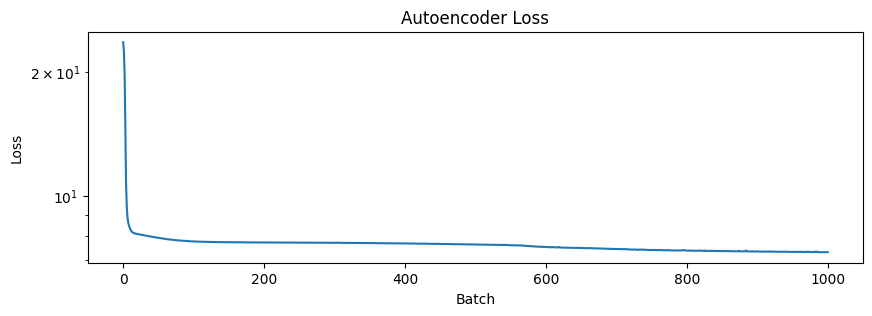

In [7]:
def plot_loss(total_loss):
    plt.figure(figsize=(10, 3))
    plt.plot(total_loss)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Autoencoder Loss')
    plt.show()
    
plot_loss(total_loss)

In [9]:
X[0]

tensor([0.8629, 0.9879, 0.8922, 0.9092, 0.8481, 0.8405, 0.8292, 0.7539, 3.7394],
       device='cuda:0')

Plot the distribution function for the latent state 

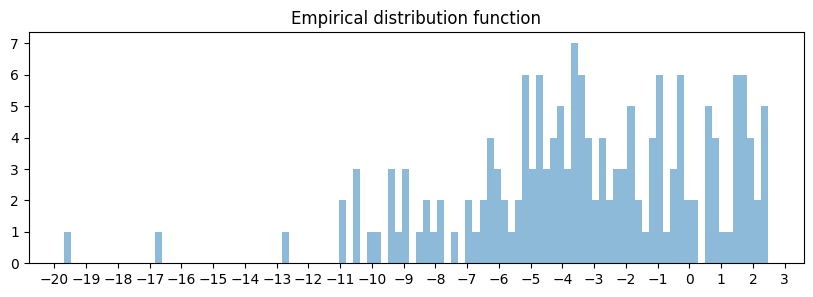

In [33]:
plt.figure(figsize=(10, 3))
plt.title("Empirical distribution function")
plt.xticks([i for i in range(-100, 100, 1)])
plt.hist(autoencoder.encoder(X).detach().cpu().numpy(), bins=100, alpha=0.5, label='Latent space')
plt.show()

Generating data